In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
# Folder names are basically class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
#Check out RGB channels
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(32, 256, 256, 3)
[0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 2 0 0 0 0 2 1 0]


In [7]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")
    

### Modeling Pipeline

In [8]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [9]:
dataset_size = dataset.cardinality().numpy()
# datase_size = len(dataset)
print(dataset_size)

68


In [10]:
# Calculate the number of samples for each split
train_size = int(0.8*dataset_size)
val_size = int(dataset_size*0.1)
test_size = int(dataset_size*0.1)

print(train_size)
print(val_size)
print(test_size)

54
6
6


In [11]:
# Create training set
train_ds = dataset.take(train_size)

# Remaining set for (Validation + Testing)
remaining_ds = dataset.skip(train_size)

# Create training set for Validation and Testing
validation_ds = remaining_ds.take(val_size)
testing_ds = remaining_ds.skip(test_size)


print(f'Training size: {train_ds.cardinality().numpy()}')
print(f'Validation size: {validation_ds.cardinality().numpy()}')
print(f'Testing size: {testing_ds.cardinality().numpy()}')

Training size: 54
Validation size: 6
Testing size: 8


In [12]:
def get_dataset_partitions_tf(dataset, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    
    assert train_size + val_size + test_size == 1
    
    # Take length of the dataset
    dataset_size = dataset.cardinality().numpy()
    
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=12)
    else:
        ds = dataset
    
    # Calculate the size of the split
    train_samples = int(train_size*dataset_size)
    val_samples = int(val_size*dataset_size)
    test_samples = int(test_size*dataset_size)
    
    # Create the training set
    train_ds = dataset.take(train_samples)
    
    # Calculate remaining
    remaining_ds = dataset.skip(train_samples)
    
    # Creating Validation + Testing set
    validation_ds = remaining_ds.take(val_samples)
    testing_ds = remaining_ds.skip(test_samples)
    
    return train_ds, validation_ds, testing_ds

In [13]:
train_ds, validation_ds, testing_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(validation_ds)

6

In [16]:
len(testing_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_ds
)

Epoch 1/50
54/54 [==============================] - 60s 1s/step - loss: 0.8753 - accuracy: 0.5324 - val_loss: 0.7308 - val_accuracy: 0.6094
Epoch 2/50
54/54 [==============================] - 54s 994ms/step - loss: 0.5898 - accuracy: 0.7367 - val_loss: 0.3177 - val_accuracy: 0.8854
Epoch 3/50
54/54 [==============================] - 54s 993ms/step - loss: 0.3644 - accuracy: 0.8501 - val_loss: 0.1870 - val_accuracy: 0.9479
Epoch 4/50
54/54 [==============================] - 54s 994ms/step - loss: 0.3001 - accuracy: 0.8900 - val_loss: 0.1650 - val_accuracy: 0.9531
Epoch 5/50
54/54 [==============================] - 54s 991ms/step - loss: 0.2710 - accuracy: 0.8924 - val_loss: 0.1651 - val_accuracy: 0.9635
Epoch 6/50
54/54 [==============================] - 56s 1s/step - loss: 0.2529 - accuracy: 0.9034 - val_loss: 0.1996 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 54s 1000ms/step - loss: 0.2122 - accuracy: 0.9155 - val_loss: 0.1299 - val_accuracy: 0.9740
Epoc

In [31]:
scores = model.evaluate(testing_ds)

8/8 [==============================] - 2s 189ms/step - loss: 0.1490 - accuracy: 0.9655


In [32]:
scores

[0.14900100231170654, 0.9655172228813171]

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accruacy')

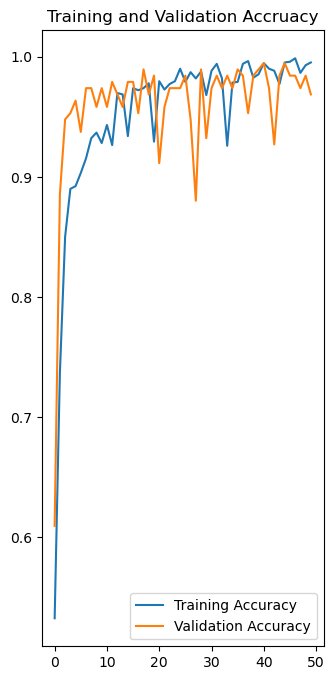

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accruacy')

First image to predict
First image's actual label: Potato___Early_blight
1/1 [==============================] - 0s 235ms/step
predicted_labe: Potato___Early_blight


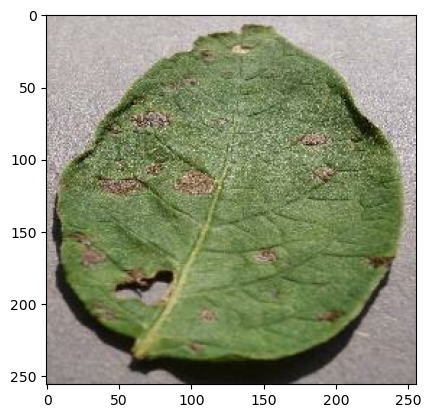

In [57]:
import numpy as np
for images_batch, labels_batch in testing_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted_labe:", class_names[np.argmax(batch_prediction[0])])

In [68]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Creating a batch
    
    prediction = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100* (np.max(prediction[0])), 2)
    return predicted_class, confidence

In [69]:
plt.figure(figsize=(15,15))
for images, labels in testing_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis('off')

1/1 [==============================] - 0s 29ms/step


In [75]:
import os

# Get the list of filenames in the models directory and filter out non-numeric ones
model_dir = 'ADD_YOUR_DIRECTORY'

# Filter filenames that are purely numeric
model_versions = [int(i) for i in os.listdir(model_dir) if i.isdigit()]

# Determine the next model version
model_version = max(model_versions + [0]) + 1

print(f"Next model version: {model_version}")


Next model version: 1


In [2]:
# model_version = 1
# model.save('ADD_YOUR_DIRECTORY')

In [3]:
# model.save(r"ADD_YOUR_DIRECTORY")
